<a href="https://colab.research.google.com/github/Praveen76/Finetune-Open-Source-LLMs-on-custom-data/blob/main/FinetuneOpenSourceLLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
!pip install tensorflow==2.14

!pip install PyYAML accelerate transformers datasets evaluate rouge_score


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
   

In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [18]:
#Basic Libraries
import os
import numpy as np
import pandas as pd
import yaml

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Text Handling Libraries
import re
import scipy.spatial
import datetime
import tensorflow as tf
import accelerate, transformers
import random

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
from huggingface_hub.hf_api import HfFolder

In [19]:
### Load relevant API Keys

file_path = '/content/drive/MyDrive/.API_KEYS/API_KEYS.yml'

with open(file_path, 'r') as file:
    api_keys = yaml.safe_load(file)

for key_name, api_key in api_keys.items():
    # Set the environment variable
    os.environ[key_name] = api_key
    if api_key == "HF_READ_API_KEY" or "HF_WRITE_API_KEY":

      # Save the token using HfFolder
      HfFolder.save_token(api_key)


# # If you want to clear the environment variable after use, you can do:
# for key_name in api_keys.keys():
#     os.environ.pop(key_name, None)


In [22]:
# # Get all environment variables

# all_env_vars = os.environ

# # Print all environment variables
# for key, value in all_env_vars.items():
#     print(f"{key}: {value}")


In [24]:
#### You can also save the huggingface read_api_key like below-
from huggingface_hub.hf_api import HfFolder
read_api_key = "<Your Hugging face read_api_key>"

HfFolder.save_token(read_api_key)


In [29]:
## Load Data
df2 = pd.read_csv("./ConvAI_Data.csv")

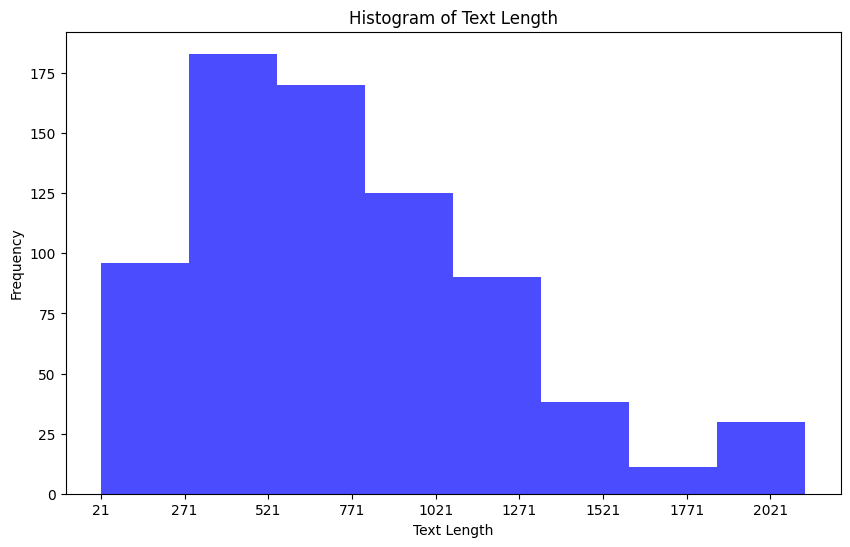

In [5]:

# Calculate the length of each text entry
text_lengths = df2.ProdDescr.apply(len)

# Specify the interval size
interval_size = 250

# Calculate the number of bins based on the interval size
num_bins = (text_lengths.max() - text_lengths.min()) // interval_size

# Plotting the histogram with specified intervals
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=num_bins, range=(text_lengths.min(), text_lengths.max()), color='blue', alpha=0.7)
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Set x-axis ticks at intervals of 250
plt.xticks(range(text_lengths.min(), text_lengths.max() + 1, interval_size))

plt.show()


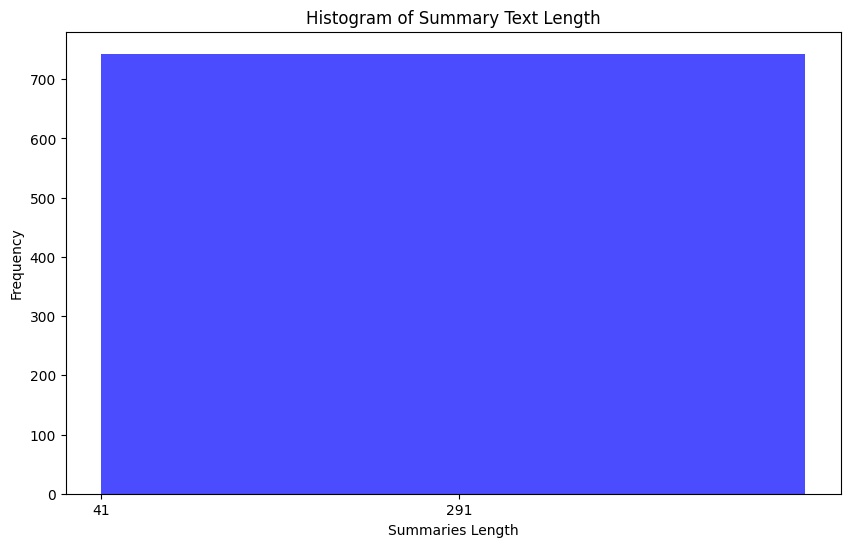

In [6]:

# Calculate the length of each text entry
text_lengths = df2.GPTSumm.apply(len)

# Specify the interval size
interval_size = 250

# Calculate the number of bins based on the interval size
num_bins = (text_lengths.max() - text_lengths.min()) // interval_size

# Plotting the histogram with specified intervals
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=num_bins, range=(text_lengths.min(), text_lengths.max()), color='blue', alpha=0.7)
plt.title('Histogram of Summary Text Length')
plt.xlabel('Summaries Length')
plt.ylabel('Frequency')

# Set x-axis ticks at intervals of 250
plt.xticks(range(text_lengths.min(), text_lengths.max() + 1, interval_size))

plt.show()


In [30]:
#Filter out Product descriptions which are shorter than 400 characters length.
df2 = df2[df2.ProdDescr.str.len() > 400]


In [8]:
# Convert the DataFrame to a datasets arrow dataset
from datasets import Dataset

data = df2[['ProdDescr', 'GPTSumm']].rename(columns={'ProdDescr': 'text', 'GPTSumm': 'summary'})
data = Dataset.from_pandas(data)
data = data.train_test_split(test_size=0.2)

## Finetune T5-small model on E-commerce data

In [ ]:


from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

checkpoint = "Praveen76/FinetunedT5Model"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=1024)  # Set model_max_length

prefix = "summarize in maximum 3 sentences: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding=True)  # Use __call__ method directly

    labels = tokenizer(examples["summary"], max_length=256, truncation=True, padding=True)  # Use __call__ method directly

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_Data = data.map(preprocess_function, batched=True)

from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=AutoModelForSeq2SeqLM.from_pretrained(checkpoint),
    padding=True,
)

import evaluate

rouge = evaluate.load("rouge")

import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

# Verify Trainer Initialization
training_args = Seq2SeqTrainingArguments(
    output_dir="T5Model_for_Ecommerce",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=15,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=False,
)

# Use the default collator provided by the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_Data['train'],
    eval_dataset=tokenized_Data['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,4.022223,0.251100,0.134600,0.212700,0.212900,19.000000
2,No log,1.304417,0.052300,0.028900,0.045000,0.045500,3.342600
3,No log,1.163007,0.000000,0.000000,0.000000,0.000000,0.000000
4,No log,1.142638,0.000000,0.000000,0.000000,0.000000,0.000000
5,No log,1.121482,0.000000,0.000000,0.000000,0.000000,0.000000
6,No log,1.099944,0.000000,0.000000,0.000000,0.000000,0.000000
7,No log,1.072993,0.000000,0.000000,0.000000,0.000000,0.000000
8,No log,1.050447,0.000000,0.000000,0.000000,0.000000,0.000000
9,No log,1.033390,0.000000,0.000000,0.000000,0.000000,0.000000
10,No log,1.018568,0.000000,0.000000,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=405, training_loss=1.7048657829378857, metrics={'train_runtime': 1626.6403, 'train_samples_per_second': 3.947, 'train_steps_per_second': 0.249, 'total_flos': 897744373678080.0, 'train_loss': 1.7048657829378857, 'epoch': 15.0})

In [ ]:
# Put huggingface's write API key
from huggingface_hub.hf_api import HfFolder
write_api_key = "<Your huggingface write_api_key>"

HfFolder.save_token(write_api_key)

In [ ]:
#Push model to huggingfacce
trainer.push_to_hub()

events.out.tfevents.1701687394.a5e0532a8ca1.49208.0:   0%|          | 0.00/4.18k [00:00<?, ?B/s]

events.out.tfevents.1701686948.a5e0532a8ca1.4720.12:   0%|          | 0.00/4.18k [00:00<?, ?B/s]

events.out.tfevents.1701687064.a5e0532a8ca1.48479.0:   0%|          | 0.00/4.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

events.out.tfevents.1701687591.a5e0532a8ca1.50752.0:   0%|          | 0.00/4.18k [00:00<?, ?B/s]

events.out.tfevents.1701687732.a5e0532a8ca1.51780.0:   0%|          | 0.00/5.77k [00:00<?, ?B/s]

events.out.tfevents.1701687919.a5e0532a8ca1.51780.1:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

'https://huggingface.co/Praveen76/T5Model_for_Ecommerce/tree/main/'

In [ ]:
df2.shape[0]

536

In [32]:
##### Load saved Model #####
summarizer = pipeline("summarization", model="Praveen76/T5Model_for_Ecommerce")


In [35]:
#################### Model Testing: Generate product description and compare it against the acutal product summary ##############

# Generate a random integer between a specified range
random_number = random.randint(0, df2.shape[0])  # Adjust the range as needed
text = df2.at[random_number,'ProdDescr']
ActualSumm = df2.at[random_number,'GPTSumm']

print("ActualSumm: ", ActualSumm,"\n")
print("PredSumm: ", summarizer(text))



ActualSumm:  This 360° PAN & TILT VIEW camera has 1080p full HD resolution and a 360-degree coverage for complete surveillance. It also features two-way talk, intelligent motion sensor, advanced night vision, mobile compatibility with Ezykam+ app, cloud monitoring, and support for Alexa and Google Assistant. The package includes the camera, USB cable, adaptor, and user manual. 

PredSumm:  [{'summary_text': 'This 1080p full HD plug & play Wi-Fi camera has a 360 degree coverage and features a built-in microphone and speaker for easy monitoring. It also has an in-built infrared LEDs for enhanced night vision and is compatible with Amazon Alexa and Google Assistant. The camera also comes with a USB cable, adaptor and user manual.'}]


In [36]:
# Generate a random integer between a specified range
random_number = random.randint(0, df2.shape[0])  # Adjust the range as needed
text = df2.at[random_number,'ProdDescr']
ActualSumm = df2.at[random_number,'GPTSumm']

print("ActualSumm: ", ActualSumm,"\n")
print("PredSumm: ", summarizer(text))

Your max_length is set to 200, but your input_length is only 189. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=94)


ActualSumm:  This USB Type-C cable is perfect for connecting your MacBook, Chromebook Pixel, or Galaxy Note 7 to standard USB Type-A devices for charging, syncing data and more. With a reversible design and fast data transfer speeds of up to 480 Mbps, this cable is also certified by USB-IF for compliance with the USB 2.0 Standard. 

PredSumm:  [{'summary_text': 'Connect USB Type-C enabled devices with standard USB type-A enabled devices. It also has a removable design for charging, powering, and syncing data, photos and music. The type-C port is half the width and one-third the height of a standard USB-A connector. It offers up to 480 Mbps data transfer speed.'}]


In [37]:
# Generate a random integer between a specified range
random_number = random.randint(0, df2.shape[0])  # Adjust the range as needed
text = df2.at[random_number,'ProdDescr']
ActualSumm = df2.at[random_number,'GPTSumm']

print("ActualSumm: ", ActualSumm,"\n")
print("PredSumm: ", summarizer(text))

ActualSumm:  This rechargeable cordless lint remover has a long-lasting battery and is perfect for at-home or travel use. It is made with premium materials and powerful suction motor to effectively remove lint, pills, bubbles, and fuzz. It is designed specifically for Indian customers and comes with a 1-year warranty for customer support. 

PredSumm:  [{'summary_text': 'This rechargeable battery has a long lasting battery that can be recharged for 60 min with 6-hour charging. It is made with premium ABS material, SS mesh cover and razor-sharp blades. It also comes with a powerful suction motor that removes lint, pills, bubbles, and fuzz of all sizes. The product is ideal for Indians and is manufactured by exclusive overseas partners.'}]


## Finetune BART-base model from Meta on E-commerce data

In [ ]:
# We'll just change the tokenizer as per the model, and output directory name, and rest of the code would remain same as above

# Use the bart-base checkpoint
checkpoint = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=1024)  # Set model_max_length

tokenized_Data = data.map(preprocess_function, batched=True)

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

# Verify Trainer Initialization
training_args = Seq2SeqTrainingArguments(
    output_dir="BARTModel_for_Ecommerce",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=15,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=False,
)

trainer.train()


Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,3.312505,0.288800,0.148200,0.244800,0.245400,20.000000
2,No log,2.269942,0.292600,0.166700,0.256400,0.257400,20.000000
3,No log,1.768612,0.311900,0.190800,0.275200,0.275300,20.000000
4,No log,1.388161,0.324000,0.210400,0.293700,0.293900,20.000000
5,No log,1.127526,0.315100,0.206100,0.287100,0.287700,20.000000
6,No log,0.937226,0.329300,0.223100,0.301700,0.302200,20.000000
7,No log,0.825157,0.330000,0.218200,0.298200,0.298800,20.000000
8,No log,0.757498,0.337800,0.231700,0.305800,0.306500,20.000000
9,No log,0.710195,0.349800,0.241800,0.314800,0.314900,20.000000
10,No log,0.688966,0.341100,0.237400,0.311900,0.312600,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=405, training_loss=1.5017100393036265, metrics={'train_runtime': 3296.4683, 'train_samples_per_second': 1.948, 'train_steps_per_second': 0.123, 'total_flos': 1899912604262400.0, 'train_loss': 1.5017100393036265, 'epoch': 15.0})

In [38]:
##### Load saved Model #####
summarizer = pipeline("summarization", model="Praveen76/BARTModel_for_Ecommerce")


In [39]:
#################### Model Testing: Generate product description and compare it against the acutal product summary ##############


# Generate a random integer between a specified range
random_number = random.randint(0, df2.shape[0])  # Adjust the range as needed
text = df2.at[random_number,'ProdDescr']
ActualSumm = df2.at[random_number,'GPTSumm']

print("ActualSumm: ", ActualSumm,"\n")
print("PredSumm: ", summarizer(text))

ActualSumm:  This 4-foot Lightning to USB-C cable allows you to quickly charge your iPhone or iPad with a USB-C fast charger, and is tested to withstand 10,000+ bends for durability. It also supports USB power delivery fast charging, allowing your iPhone 8 or later to reach up to 50% charge in just 30 minutes when paired with an 18W or higher USB-C power adapter. The Belkin difference means this cable has been designed specifically for Apple devices and is MFi 

PredSumm:  [{'summary_text': 'This 4-foot Lightning cable can connect your iPhone or Ipad to a USB-C Fast Charger for a quick power boost or sync photos and videos with your computer. It has been tested to withstand 10,000+ bends for ultimate longevity and has been certified by Apple Performance Standards. The Belkin Difference means that an electronic accessory has been specifically designed specifically to connect to your phone or iPad for fast charging.'}]


In [44]:

# Generate a random integer between a specified range
random_number = random.randint(0, df2.shape[0])  # Adjust the range as needed
text = df2.at[random_number,'ProdDescr']
ActualSumm = df2.at[random_number,'GPTSumm']

print("ActualSumm: ", ActualSumm,"\n")
print("PredSumm: ", summarizer(text))

ActualSumm:  This immersion water heater is ISI certified and has a wattage of 1500 Watts. It can be used for beverages and water, with a power requirement of 230-250 V and 50-60 hz. It also comes with a 2-year warranty and a specially designed heating element for quick heating. 

PredSumm:  [{'summary_text': 'Immersion Water heater has a wattage of 1500 Watts and is ISI certified. It can heat beverages, water, and more with a power requirement of 230-250 V. It also has a copper tube element for long-lasting heating. The product comes with a 2-year warranty.'}]


In [41]:

# Generate a random integer between a specified range
random_number = random.randint(0, df2.shape[0])  # Adjust the range as needed
text = df2.at[random_number,'ProdDescr']
ActualSumm = df2.at[random_number,'GPTSumm']

print("ActualSumm: ", ActualSumm,"\n")
print("PredSumm: ", summarizer(text))

ActualSumm:  This rechargeable cordless lint remover has a long-lasting battery and is perfect for at-home or travel use. It is made with premium materials and powerful suction motor to effectively remove lint, pills, bubbles, and fuzz. It is designed specifically for Indian customers and comes with a 1-year warranty for customer support. 

PredSumm:  [{'summary_text': 'This rechargeable cordless lint remover is perfect for at-home use or while traveling, with a long-lasting battery and powerful suction motor. Made for Indian consumers, it comes with a 1 year warranty and is ideal for Indian customers.'}]
